In [2]:
from utils import conv
from utils import NN as nn
from utils import dataprepare as dp
from utils import Feature_extract as fe

import cv2
import math
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

In [3]:
# import os
# # Load images and filenames
# train_images, train_image_filenames = dp.load_images_from_folder_filenames('rev_patching/patch_image')

# # Extract feature maps from images
# feature_maps = [fe.extract(image) for image in train_images]

# # Save feature maps with the same filenames as the original images
# for i, (feature_map, image_filename) in enumerate(zip(feature_maps, train_image_filenames)):
#     image_name = os.path.splitext(image_filename)[0]
#     pil_image = Image.fromarray(feature_map)
#     pil_image.save(f'rev_patching/feature_extract_image/{image_name}.png', format='PNG')

In [4]:
# Load images and ground truth labels
images_path = 'patching_fix/patch_image'
feature_images_path = 'patching_fix/extract_ori'
ground_truths_path = 'patching_fix/patch_ground'

images_load = dp.load_images_from_folder(images_path)
feature_images_load = dp.load_images_from_folder(feature_images_path)
ground_truths = dp.load_ground_truth_from_folder(ground_truths_path)

In [5]:
feature_images_train = feature_images_load[:math.ceil(len(feature_images_load)*0.8)] 
image_label_train = ground_truths[:math.ceil(len(ground_truths)*0.8)]

image_test = images_load[math.ceil(len(images_load)*0.8):]
image_label_test = ground_truths[math.ceil(len(ground_truths)*0.8):]

In [6]:
len(feature_images_train)

2021

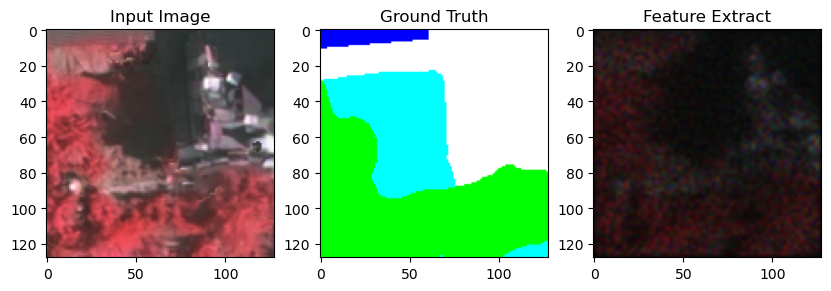

In [7]:
indeks = 1597
# Plot the images
plt.figure(figsize=(10, 3))
plt.subplot(1, 3, 1)
plt.imshow(images_load[indeks])
plt.title('Input Image')

plt.subplot(1, 3, 2)
plt.imshow(ground_truths[indeks])
plt.title('Ground Truth')

plt.subplot(1, 3, 3)
plt.imshow(feature_images_load[indeks])
plt.title('Feature Extract')

plt.show()

In [8]:
# Prepare data
X, y = dp.prepare_data(feature_images_train, image_label_train)

In [9]:
len(X)

3

In [10]:
# Normalize the features
X_normalized = X / 255.0

In [11]:
X_normalized.shape

(3, 33112064)

In [44]:
# Initialize the neural network
input_size = X_normalized.shape[0]
hidden_size = 2  # hidden neuron
output_size = 2  # 2 classes: vegetation and non-vegetation
learning_rate = 0.001
num_epochs = 20
toleransi_error = 0.1

# Initialize the neural network with adjusted hidden size
model = nn.NeuralNetwork(input_size, hidden_size, output_size)

# Check the shape of weights_hidden_output
print(model.weights_hidden_output.shape)

(2, 2)


In [45]:
# Inisialisasi awal bobot bias before train
print(model.weights_hidden_output)
print(model.bias_hidden_output)
print(model.weights_input_hidden)
print(model.bias_input_hidden)

[[ 0.1554839  -0.19598098]
 [ 0.49978505  0.37274977]]
[[0. 0.]]
[[ 1.          0.1180934 ]
 [-1.         -1.        ]
 [-0.16073002  0.49877187]]
[[0. 0.]]


In [46]:
# Training loop with batching
batch_size = 128
num_batches = X_normalized.shape[1] // batch_size
losses = []
accuracies = []

threshold = 0.5  # Threshold untuk mengklasifikasikan output

for epoch in range(num_epochs):
    epoch_loss = 0
    correct_predictions = 0
    total_samples = X_normalized.shape[1]  # Total sampel dalam satu epoch
    
    for i in range(num_batches):
        # Get batch data
        start_idx = i * batch_size
        end_idx = (i + 1) * batch_size
        X_batch = X_normalized[:, start_idx:end_idx].T
        y_batch = y[:, start_idx:end_idx].T
        
        # Forward pass
        output = model.forward(X_batch)
        
        # Compute loss
        loss = nn.binary_cross_entropy(y_batch, output)
        epoch_loss += loss
        
        # Compute predictions based on threshold
        predicted_labels = (output >= threshold).astype(int)
        
        # Compute accuracy
        true_labels = y_batch
        correct_predictions += np.sum(predicted_labels == true_labels)
        
        # Backpropagation
        model.backward(X_batch, y_batch, learning_rate)
    
    # Average loss for the epoch
    epoch_loss /= num_batches
    losses.append(epoch_loss)
    
    # Accuracy for the epoch
    accuracy = 1 - epoch_loss
    accuracies.append(accuracy)
    
    # Print loss
    if epoch % 1 == 0:
        print(f'Epoch {epoch+1}, Loss: {epoch_loss}, Accuracy: {accuracy}')
    
    # Early stopping
    if epoch_loss < toleransi_error:
        print("Training berhenti karena error sudah kurang dari 0.1")
        print(f'Epoch {epoch+1}, Loss: {epoch_loss}, Accuracy: {accuracy}')
        break

Epoch 1, Loss: 0.27163924506652165, Accuracy: 0.7283607549334783
Epoch 2, Loss: 0.266729158846624, Accuracy: 0.7332708411533759
Epoch 3, Loss: 0.26647959615082445, Accuracy: 0.7335204038491756
Epoch 4, Loss: 0.26609334019314845, Accuracy: 0.7339066598068515
Epoch 5, Loss: 0.2644405913613673, Accuracy: 0.7355594086386327
Epoch 6, Loss: 0.26280519336190566, Accuracy: 0.7371948066380943
Epoch 7, Loss: 0.26179196368418595, Accuracy: 0.7382080363158141
Epoch 8, Loss: 0.2612721806239257, Accuracy: 0.7387278193760742
Epoch 9, Loss: 0.26112302038724466, Accuracy: 0.7388769796127553
Epoch 10, Loss: 0.26094323296786076, Accuracy: 0.7390567670321393
Epoch 11, Loss: 0.2609405010442625, Accuracy: 0.7390594989557375
Epoch 12, Loss: 0.2609082037905371, Accuracy: 0.739091796209463
Epoch 13, Loss: 0.26087547577448994, Accuracy: 0.73912452422551
Epoch 14, Loss: 0.26084165551907806, Accuracy: 0.739158344480922
Epoch 15, Loss: 0.2608694566312509, Accuracy: 0.7391305433687492
Epoch 16, Loss: 0.260890339946

In [49]:
# Nilai awal bobot bias after train
print(model.weights_hidden_output)
print(model.bias_hidden_output)
print(model.weights_input_hidden)
print(model.bias_input_hidden)

[[-0.78224552  0.78224552]
 [ 3.94819671 -3.94819671]]
[[ 1.02027161 -0.02027161]]
[[ 45.92721522 -13.20697089]
 [-60.70172361  -6.89439074]
 [-37.97780135  -2.57614358]]
[[ 1.07707606 -2.90245589]]


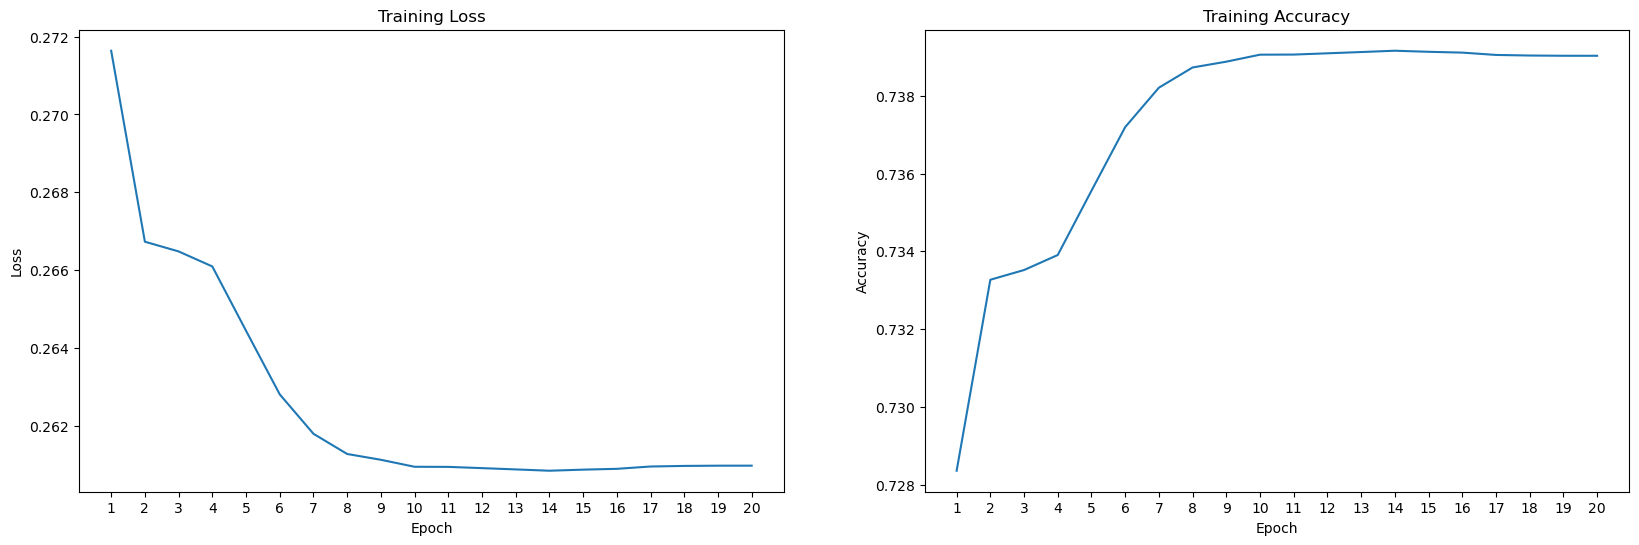

In [50]:
# Plot loss and accuracy
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(losses) + 1), losses)  # Menyesuaikan sumbu x
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(1, len(losses) + 1))  # Menyesuaikan nilai pada sumbu x

plt.subplot(1, 2, 2)
plt.plot(range(1, len(accuracies) + 1), accuracies)  # Menyesuaikan sumbu x
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(range(1, len(accuracies) + 1))  # Menyesuaikan nilai pada sumbu x

plt.show()

In [51]:
# Save weights to a file
def save_weights(weights_hidden_output, bias_hidden_output, weights_input_hidden, bias_input_hidden, filename):
    with open(filename, 'wb') as f:
        np.savez(f, weights_hidden_output=weights_hidden_output, bias_hidden_output=bias_hidden_output,
                 weights_input_hidden=weights_input_hidden, bias_input_hidden=bias_input_hidden)

# Example usage
weights_hidden_output = model.weights_hidden_output
bias_hidden_output = model.bias_hidden_output
weights_input_hidden = model.weights_input_hidden
bias_input_hidden = model.bias_input_hidden
save_weights(weights_hidden_output, bias_hidden_output, weights_input_hidden, bias_input_hidden, '3. Bobot_skenario_3.npz')

In [52]:
print(model.output)

[[ 5.97913953e-01  4.02086047e-01]
 [ 5.50711456e-01  4.49288544e-01]
 [ 7.57744270e-01  2.42255730e-01]
 [ 1.02857530e+00 -2.85752974e-02]
 [ 1.02813367e+00 -2.81336725e-02]
 [ 9.00084421e-01  9.99155785e-02]
 [ 8.23296969e-01  1.76703031e-01]
 [ 9.96195971e-01  3.80402860e-03]
 [ 1.05503739e+00 -5.50373856e-02]
 [ 1.05112806e+00 -5.11280636e-02]
 [ 1.02940874e+00 -2.94087362e-02]
 [ 8.97483302e-01  1.02516698e-01]
 [ 8.00709291e-01  1.99290709e-01]
 [ 9.20569366e-01  7.94306338e-02]
 [ 1.02643036e+00 -2.64303584e-02]
 [ 1.03078231e+00 -3.07823094e-02]
 [ 1.02299781e+00 -2.29978125e-02]
 [ 9.30595263e-01  6.94047369e-02]
 [ 7.76040100e-01  2.23959900e-01]
 [ 7.42599572e-01  2.57400428e-01]
 [ 8.29629033e-01  1.70370967e-01]
 [ 9.48339515e-01  5.16604845e-02]
 [ 9.61355286e-01  3.86447135e-02]
 [ 8.91871032e-01  1.08128968e-01]
 [ 8.57286466e-01  1.42713534e-01]
 [ 8.91242111e-01  1.08757889e-01]
 [ 9.75139131e-01  2.48608686e-02]
 [ 1.01662560e+00 -1.66256013e-02]
 [ 1.03172421e+00 -3

before argmax 
 [[ 1.02027165 -0.02027165]
 [ 1.02027165 -0.02027165]
 [ 1.02027165 -0.02027165]
 ...
 [ 1.02027161 -0.02027161]
 [ 1.02027161 -0.02027161]
 [ 1.02027161 -0.02027161]]
after argmax 
 [[0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


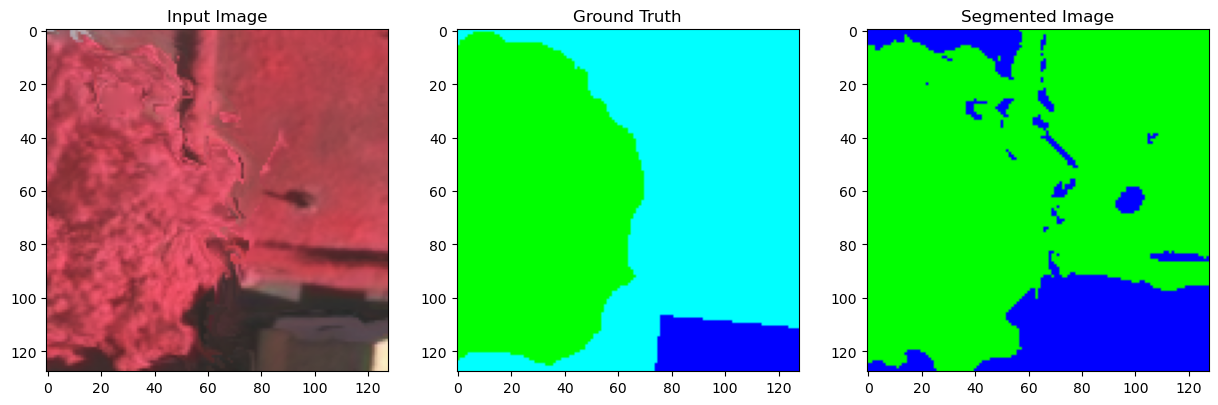

In [53]:
# Define colors for vegetation and non-vegetation
vegetation_color = [0, 255, 0]  # Green
non_vegetation_color = [0, 0, 255]  # Blue

# Visualize segmentation results for one image
indexing = 2
input_image = images_load[indexing]
ground_truth = ground_truths[indexing]
features_get = fe.extract(input_image)

# Preprocess the input image
input_image_reshaped = cv2.resize(input_image, (128, 128)) / 255.0
features = input_image_reshaped.reshape(-1, 3)  # Remove the transpose operation here

# Predict segmentation mask
predicted_mask = model.forward(features)
pred_before = predicted_mask
print('before argmax \n',pred_before)
predicted_mask = predicted_mask.argmax(axis=1).reshape(128, 128)
pred_after= predicted_mask
print('after argmax \n',pred_after)
# print(len(predicted_mask))
# Create segmented image
segmented_image = np.zeros((128, 128, 3), dtype=np.uint8)

# Assign colors based on predicted mask
segmented_image[predicted_mask == 0] = non_vegetation_color
segmented_image[predicted_mask == 1] = vegetation_color

# Plot the images
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(input_image)
plt.title('Input Image')

plt.subplot(1, 3, 2)
plt.imshow(ground_truth)
plt.title('Ground Truth')

plt.subplot(1, 3, 3)
plt.imshow(segmented_image)
plt.title('Segmented Image')

plt.show()

In [24]:
print('nilai prediksi \n', pred_before[50:60])
print('hasil argmax \n', pred_after[2][50:60])

nilai prediksi 
 [[ 0.91309717  0.08292262]
 [ 0.9657361   0.03225555]
 [ 0.99289534  0.00696309]
 [ 1.01450834 -0.01145675]
 [ 1.01434747 -0.0074396 ]
 [ 1.00350878  0.00605556]
 [ 0.99560038  0.01536018]
 [ 0.99342313  0.01787501]
 [ 0.99394047  0.01728584]
 [ 0.99504067  0.01600845]]
hasil argmax 
 [0 0 0 0 0 0 0 0 0 0]


Indeks yang ada warna merah
> 2007
> 2011 - 2013

Keperluan BI indeks analisa : 6, 19, 2012, 3192

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(input_image)
plt.title('Input Image')

plt.subplot(1, 3, 2)
plt.imshow(ground_truth)
plt.title('Ground Truth')

plt.subplot(1, 3, 3)
plt.imshow(segmented_image)
plt.title('Segmented Image')

=-=-=--=-=

plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)
plt.imshow(input_image)
plt.title('Input Image')

plt.subplot(2, 2, 2)
plt.imshow(features_get)
plt.title('Feature Maps')

plt.subplot(2, 2, 3)
plt.imshow(ground_truth)
plt.title('Ground Truth')

plt.subplot(2, 2, 4)
plt.imshow(segmented_image)
plt.title('Segmented Image')